# Machine Learning: An Approach to Classifying Internet Protocol Traffic

In [66]:
#Packages
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
import seaborn as sn
import pandas as pd
import numpy as np
import pylab as pl
import requests
import time
import json
import os

In [ ]:
#Instead of using Wireshark to export json files from pcaps, this cell can generate the json pretty quickly.

#Assuming user has tshark's most updated version, to include json exportation capability.

user_input = "somepcap" #(Example: for somepcap.pcap, enter "somepcap")
print("Analyzing {}.pcap ...".format(user_input))

#Convert pcap to json
os.system("tshark -r {}.pcap -T json >{}.json".format(user_input,user_input))
json_file = "{}.json".format(user_input)

#If no tshark, continue below with an uploaded json file as a wireshark export.

In [13]:
#Load json file.
json_file = "Practice2.json" #<-------Delete this line if the cell above was executed.

with open(json_file,"r") as f:
    data = json.loads(f.read())

In [31]:
#pd.set_option('display.max_columns',330) #<-------Used for preliminary analysis, helps decide which columns I can keep.

# Json_normalize with a max_level=4 extracts all branches from data.
# We will clean this up later.
dataframe=pd.json_normalize(data,max_level=4).dropna(axis=1,how='all').replace(np.nan,'0')

dataframe=dataframe[['_source.layers.frame.frame.time','_source.layers.frame.frame.time_epoch',
                    '_source.layers.frame.frame.number','_source.layers.frame.frame.len',
                    '_source.layers.frame.frame.protocols','_source.layers.frame.frame.coloring_rule.name',
                    '_source.layers.frame.frame.coloring_rule.string','_source.layers.eth.eth.dst_tree.eth.dst_resolved',
                    '_source.layers.eth.eth.dst_tree.eth.dst.oui','_source.layers.eth.eth.dst_tree.eth.dst.oui_resolved',
                    '_source.layers.eth.eth.src_tree.eth.src_resolved','_source.layers.eth.eth.src_tree.eth.src.oui',
                    '_source.layers.eth.eth.src_tree.eth.src.oui_resolved',
                    '_source.layers.ip.ip.version','_source.layers.ip.ip.len',
                    '_source.layers.ip.ip.ttl','_source.layers.ip.ip.proto',
                    '_source.layers.ip.ip.checksum.status','_source.layers.ip.ip.src','_source.layers.ip.ip.dst',
                    '_source.layers.tcp.tcp.srcport','_source.layers.tcp.tcp.dstport',
                    '_source.layers.tcp.tcp.len','_source.layers.tcp.tcp.seq',
                    '_source.layers.tcp.tcp.seq_raw','_source.layers.tcp.tcp.nxtseq',
                    '_source.layers.tcp.tcp.ack','_source.layers.tcp.tcp.ack_raw',
                    '_source.layers.tcp.tcp.hdr_len','_source.layers.tcp.tcp.flags_tree.tcp.flags.push',
                    '_source.layers.udp.udp.srcport','_source.layers.udp.udp.dstport',
                    '_source.layers.udp.udp.port','_source.layers.udp.udp.length']]

In [49]:
#Timestamp/Numerics
dataframe['_source.layers.frame.frame.time']=pd.to_datetime(dataframe['_source.layers.frame.frame.time'])
dataframe['_source.layers.frame.frame.time_epoch']= pd.to_numeric(dataframe['_source.layers.frame.frame.time_epoch'])

#Separation of IPs
#Example: 123.234.345.456 -> [123,234,345,456]

#'_source.layers.ip.ip.src'
dataframe=dataframe[dataframe['_source.layers.ip.ip.src']!='0'] #Will not accept empty IPs
dataframe['_source.layers.ip.ip.src_a'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.src']).split('.')[0],axis=1)
dataframe['_source.layers.ip.ip.src_b'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.src']).split('.')[1],axis=1)
dataframe['_source.layers.ip.ip.src_c'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.src']).split('.')[2],axis=1)
dataframe['_source.layers.ip.ip.src_d'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.src']).split('.')[3],axis=1)

#'_source.layers.ip.ip.dst'
dataframe=dataframe[dataframe['_source.layers.ip.ip.dst']!='0'] #Will not accept empty IPs
dataframe['_source.layers.ip.ip.dst_a'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.dst']).split('.')[0],axis=1)
dataframe['_source.layers.ip.ip.dst_b'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.dst']).split('.')[1],axis=1)
dataframe['_source.layers.ip.ip.dst_c'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.dst']).split('.')[2],axis=1)
dataframe['_source.layers.ip.ip.dst_d'] = dataframe.apply(lambda x: (x['_source.layers.ip.ip.dst']).split('.')[3],axis=1)

C:\Users\M69456\Miniconda3\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [ ]:
#Still need to present some basic/key data analysis here. 
#Remember that even just the fundamentals might be insightful for others. 


# Machine learning

In [37]:
#Tools for ML analysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from numpy.random import RandomState

In [65]:
#Set X,y variables for ML analysis

#For the sake of numerical/categorical classification and ML, we eliminate non-numeric metadata.
#We will use X,y throughout the ML portion of this analysis.
#Let's apply pandas.to_numeric() just to be safe.

X = dataframe.drop(columns=['_source.layers.frame.frame.time','_source.layers.ip.ip.src','_source.layers.ip.ip.dst',
                           '_source.layers.eth.eth.src_tree.eth.src.oui_resolved','_source.layers.eth.eth.src_tree.eth.src_resolved',
                           '_source.layers.eth.eth.dst_tree.eth.dst.oui_resolved','_source.layers.eth.eth.dst_tree.eth.dst_resolved',
                           '_source.layers.frame.frame.coloring_rule.string','_source.layers.frame.frame.coloring_rule.name',
                           '_source.layers.frame.frame.protocols','_source.layers.udp.udp.srcport','_source.layers.udp.udp.dstport',
                           '_source.layers.udp.udp.port','_source.layers.udp.udp.length'])\
                           .apply(pd.to_numeric).dropna(axis=1,how='all').replace(np.nan,'0')

#For simplicity, we decided to treat our "protocols" as the target values.
y = dataframe['_source.layers.frame.frame.coloring_rule.name']

In [20]:
#Set test,training params
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#Naive bayes
gnb = GaussianNB()

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)



In [21]:
#Naive bayes classifier
gnb.fit(X_train, y_train)

y_pred1 = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred1).sum()))

Number of mislabeled points out of a total 507 points : 87


In [22]:

# Model Accuracy, how often is the classifier correct?
print("Naive Bayes Accuracy:",metrics.accuracy_score(y_test, y_pred1))

Naive Bayes Accuracy: 0.8284023668639053


In [23]:
#Random forest classifier
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred2=clf.predict(X_test)

In [24]:
print("Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred2).sum()))

Number of mislabeled points out of a total 507 points : 37


In [25]:
# Model Accuracy, how often is the classifier correct?
print("Random Forest Classifier Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Random Forest Classifier Accuracy: 0.9270216962524654


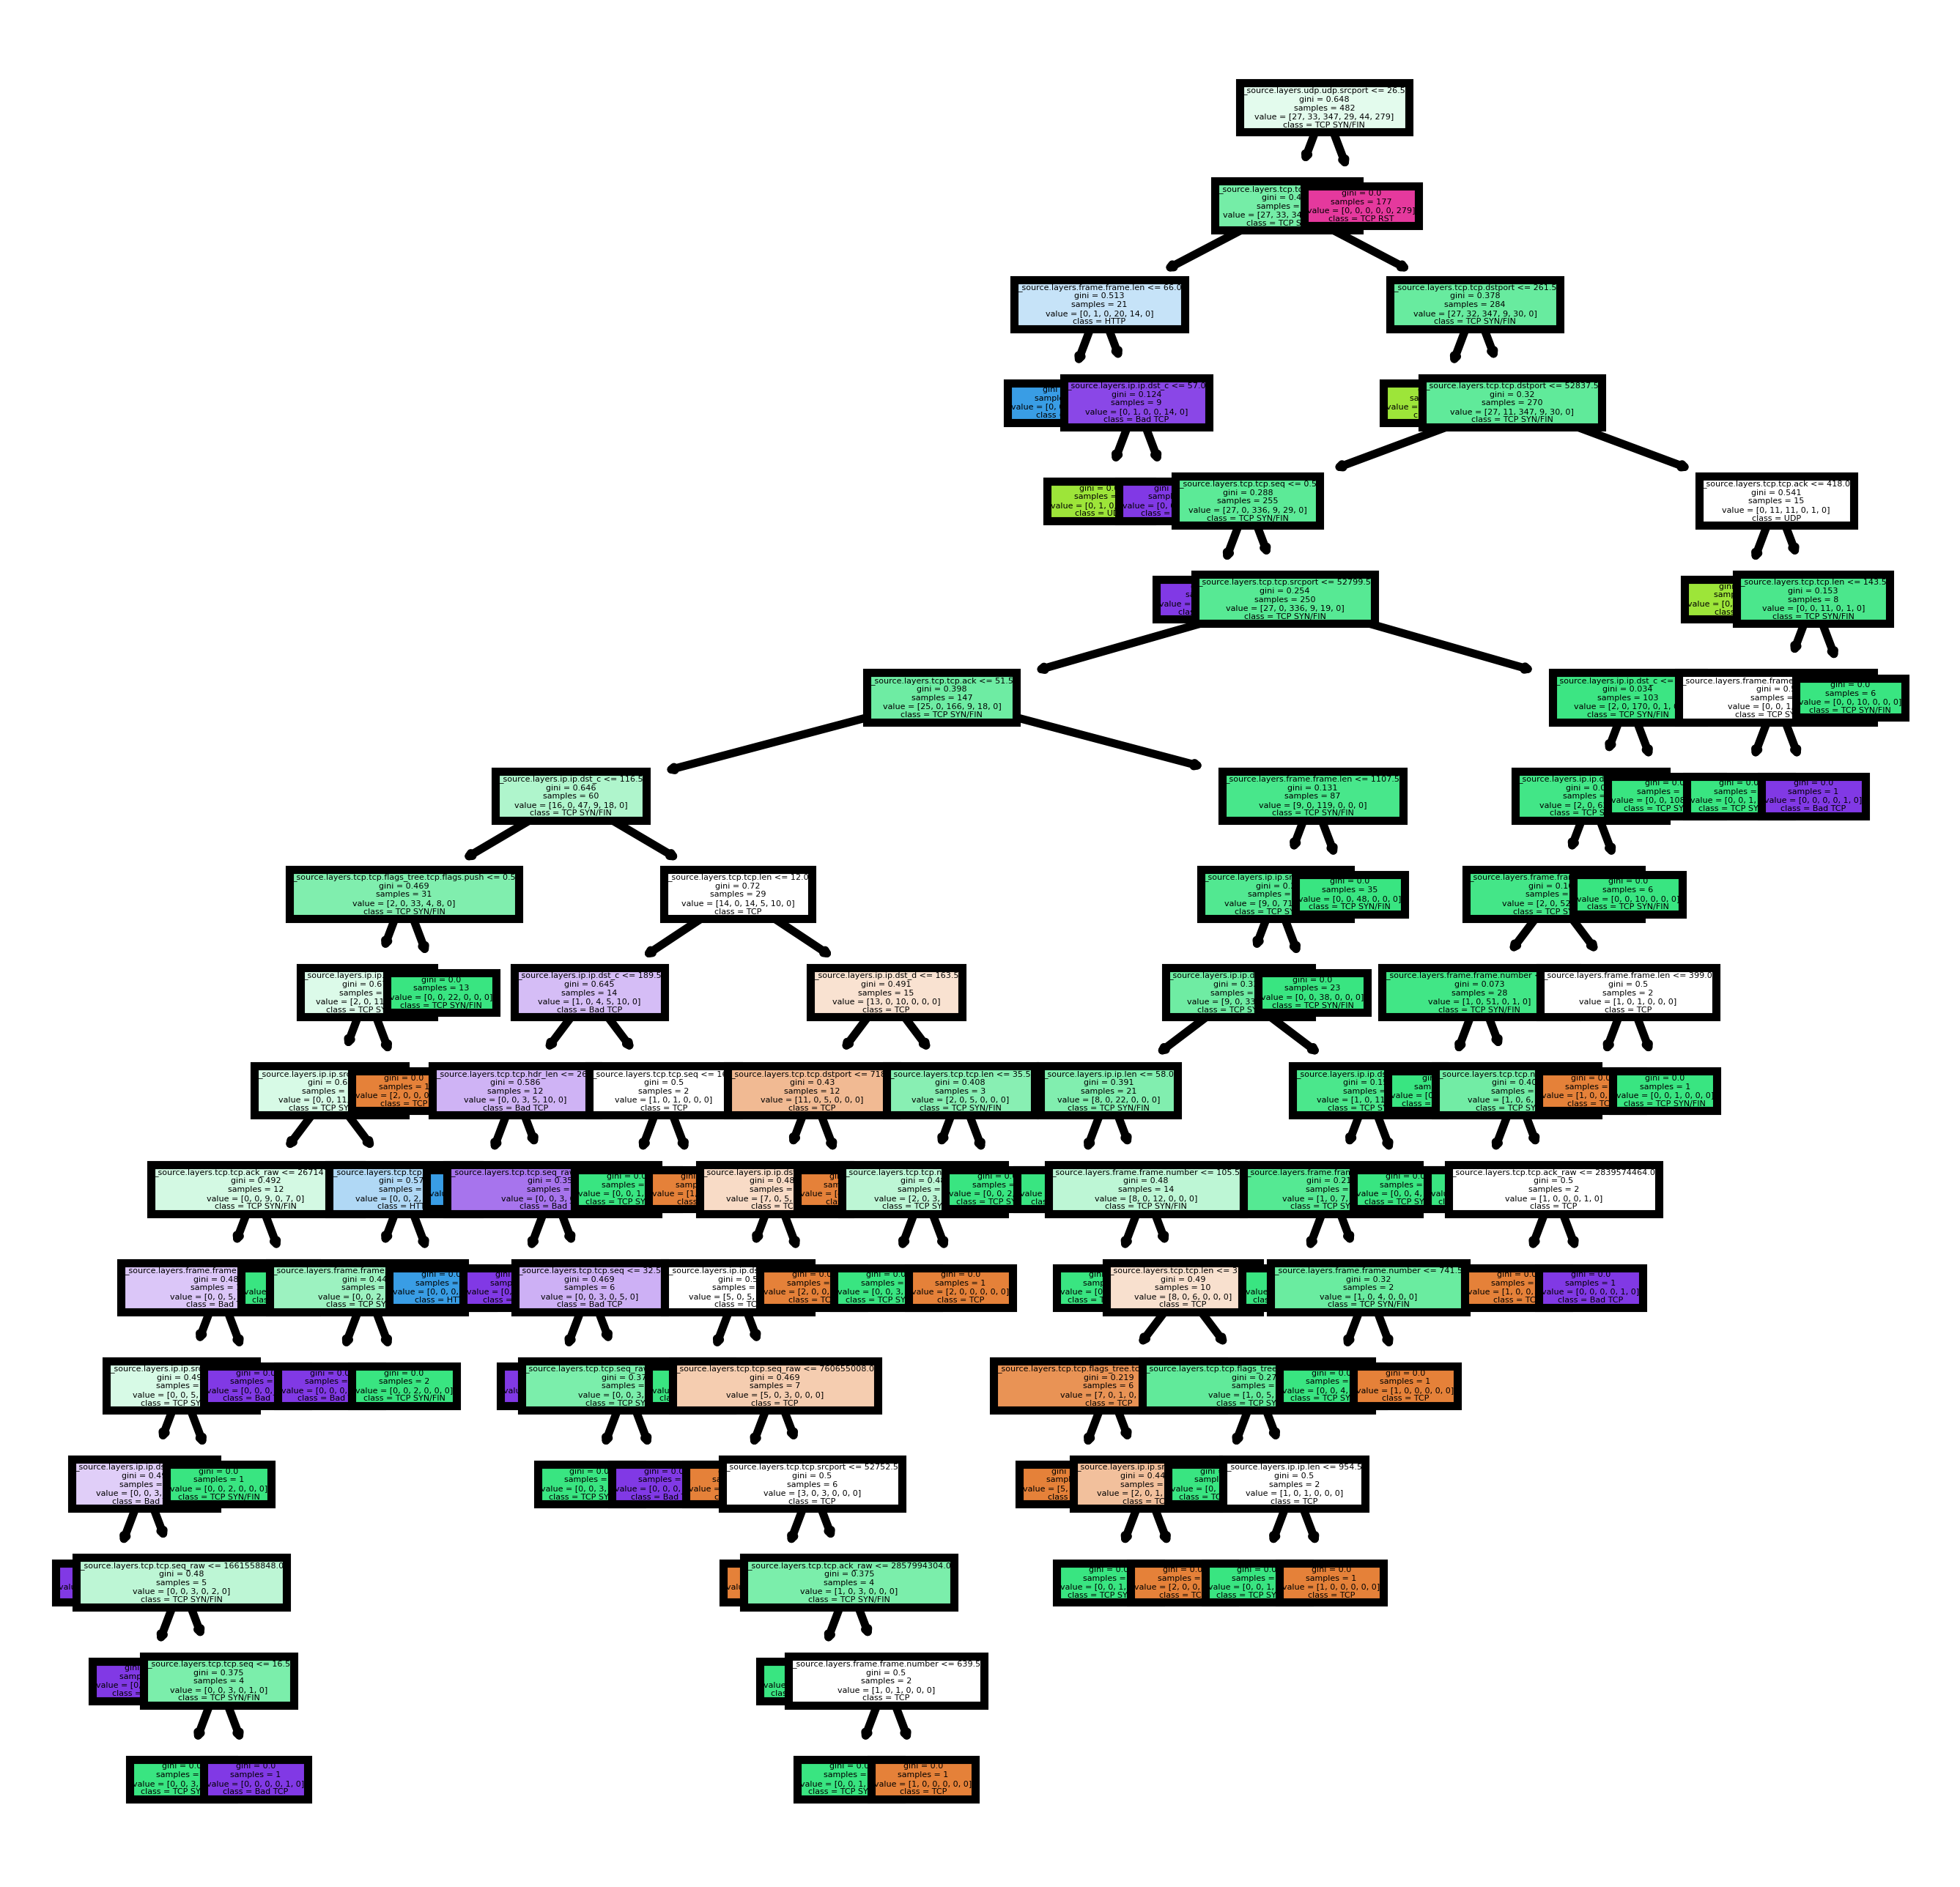

In [27]:

#dataset
df = X
df['target'] = y

# Arrange Data into Features Matrix and Target Vector
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Random Forests in `scikit-learn` (with N = 100)
rf = RandomForestClassifier(n_estimators=100,
                            random_state=0)
rf.fit(X_train, y_train)

fn=X.columns
cn=dataframe['_source.layers.frame.frame.coloring_rule.name'].value_counts().index
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

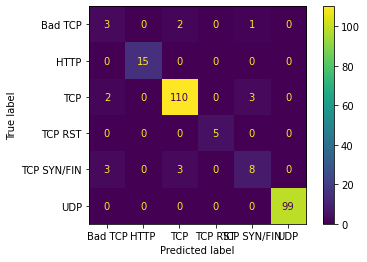

In [28]:
plot_confusion_matrix(rf, X_test, y_test)  # doctest: +SKIP
plt.show()

In [29]:
# Model Accuracy, how often is the classifier correct?
y_pred=rf.predict(X_test)
print("Random Forest Classifier Accuracy:",metrics.accuracy_score(y_test, y_pred))

Random Forest Classifier Accuracy: 0.9448818897637795


Order of analysis:

Classification
   1. RFC,ABC
   2. NB, BernNB
   3. MLP
   4. PCA, DBSCAN, KMeans
   5. *GaussianProcessClassifier
   6. *KNeighborsClassifier

In [ ]:
#Future analysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier

## Extra, extra...

In [76]:
#Upload and modify dataframe.
spammers = pd.read_excel('SpamHaus.xlsx',header=0)
spammers['Date']=pd.to_datetime(spammers['Date'])
spammers['Count'] = 1
spammers

,IP Address,ISP,Identity,Source Country,Source,Date,Count
0,94.159.9.54/32,megaton-net.ru,Andreas Pohl,Germany,Spamhaus Block List (SBL),2013-01-14,1
1,91.202.21.150/32,prokma.ru,Andreas Pohl,Germany,Spamhaus Block List (SBL),2012-10-08,1
2,94.231.180.250/32,galcom.net.ua,Andreas Pohl,Germany,Spamhaus Block List (SBL),2012-04-06,1
3,82.200.37.78/32,zsttk.ru,Andreas Pohl,Germany,Spamhaus Block List (SBL),2012-05-13,1
4,109.195.113.248/32,ertelecom.ru,Andreas Pohl,Germany,Spamhaus Block List (SBL),2012-10-08,1
...,...,...,...,...,...,...,...
2248,203.31.88.0/23,APNIC,Zombies,unknown,Spamhaus Block List (SBL),2003-04-01,1
2249,204.89.224.0/24,ARIN,Zombies,unknown,Spamhaus Block List (SBL),2003-10-30,1
2250,204.52.255.0/24,ARIN,Zombies,unknown,Spamhaus Block List (SBL),2004-01-19,1
2251,206.197.28.0/24,ARIN,Zombies,unknown,Spamhaus Block List (SBL),2004-02-16,1


In [ ]:
#/32-bit is cidrl
#Complete unique IP Address

#/24 - last 8-bit are masked



<AxesSubplot:xlabel='Date'>

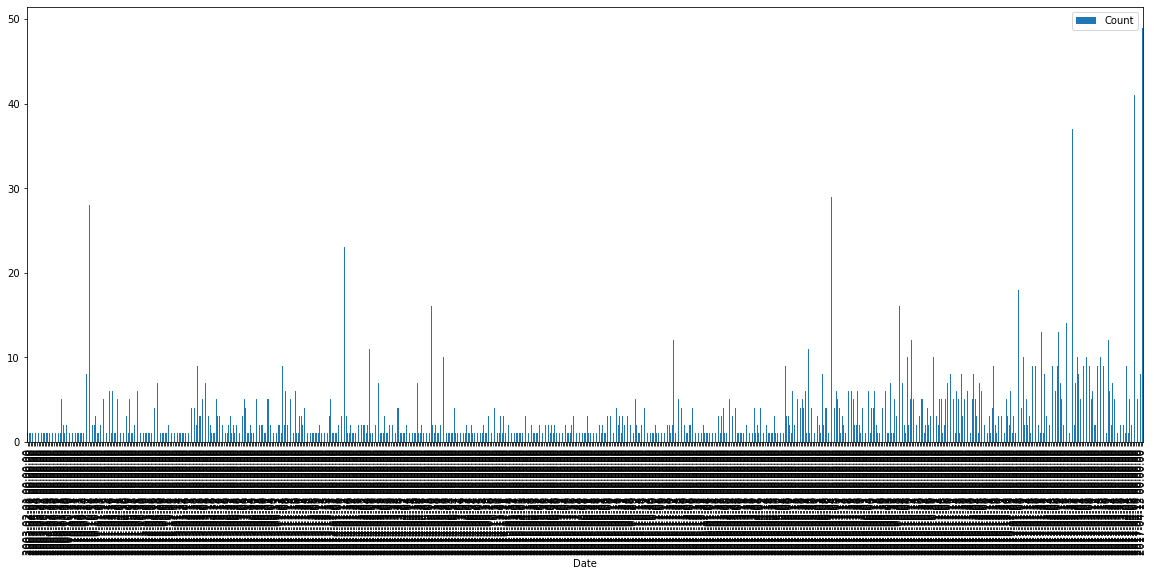

In [85]:
spammers.pivot_table(index="Date",values="Count",aggfunc='sum').plot(kind="bar",
                                                                     figsize=(20,8),
                                                                     legend=True)

In [68]:
spammers.describe()

,IP Address,ISP,Identity,Source Country,Source,Date
count,2253,2253,2253,2253,2253,2253
unique,2242,505,22,13,1,723
top,91.203.142.118/32,hgc.com.hk,"Guangzhou-Seoul Information Technology Co., Lt...",China,Spamhaus Block List (SBL),2017-04-13 00:00:00
freq,6,475,1183,1520,2253,49


In [71]:
spammers['IP Address'].value_counts()

91.203.142.118/32     6
91.203.141.192/32     6
118.26.116.127/32     2
148.7.0.0/16          1
163.47.19.0/24        1
                     ..
203.156.197.39/32     1
202.162.214.198/32    1
118.26.116.142/32     1
192.43.156.0/22       1
103.75.46.19/32       1
Name: IP Address, Length: 2242, dtype: int64